In [1]:
import torch, detectron2 

In [2]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

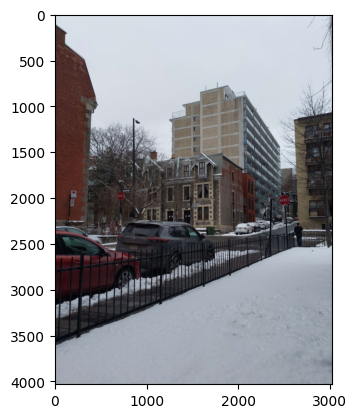

In [4]:
img = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/mtl_street_scene.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

[03/16 16:18:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  2,  2,  2,  2,  2,  2,  2, 11,  0], device='cuda:0')
Boxes(tensor([[2597.4512, 2269.7278, 2697.4402, 2529.9878],
        [   6.8831, 2315.7593,  931.5431, 3177.4521],
        [ 645.6266, 2246.0076, 1756.9326, 2852.1716],
        [1959.9698, 2277.2905, 2149.3018, 2401.8379],
        [2187.5886, 2242.7947, 2322.8484, 2348.6851],
        [2093.7871, 2273.4519, 2227.8198, 2382.5200],
        [2512.0627, 2214.7949, 2580.9280, 2282.6006],
        [2587.5271, 2212.0024, 2649.0593, 2259.5422],
        [2437.3003, 1972.5376, 2554.2192, 2083.7046],
        [ 604.8433, 2235.1919,  662.9166, 2413.3311]], device='cuda:0'))


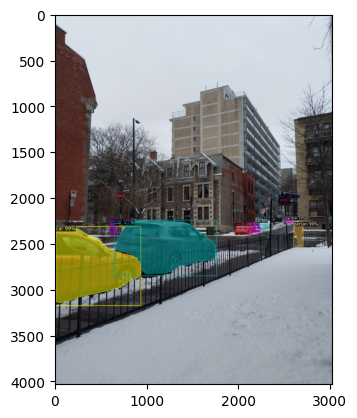

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

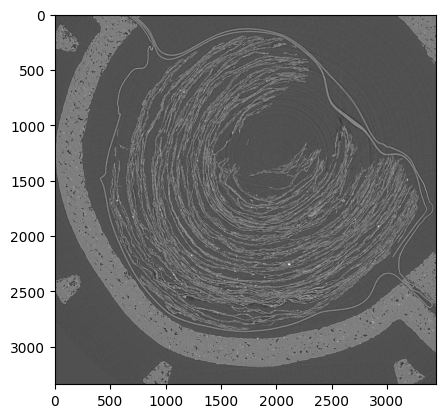

In [8]:
scroll_img = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/01250.png")
scroll_img = cv2.cvtColor(scroll_img, cv2.COLOR_BGR2RGB)
plt.imshow(scroll_img)

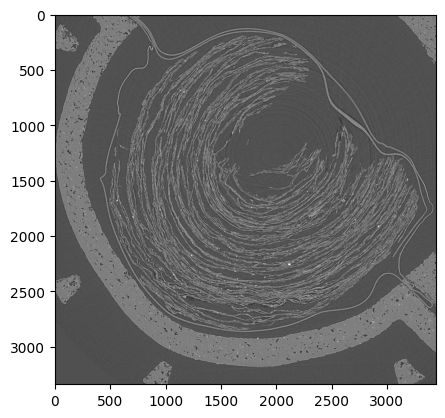

In [9]:

sci_outputs = predictor(scroll_img)
sci_v = Visualizer(scroll_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
plt.imshow(sci_out.get_image()[:, :, ::-1])

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/train/train.json", "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/train")
register_coco_instances("my_dataset_val", {}, "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val/val.json", "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val")

In [11]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

WARNING [03/16 16:18:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 16:18:14 d2.data.datasets.coco]: Loaded 5 images in COCO format from /home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/train/train.json
WARNING [03/16 16:18:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 16:18:14 d2.data.datasets.coco]: Loaded 2 images in COCO format from /home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val/val.json


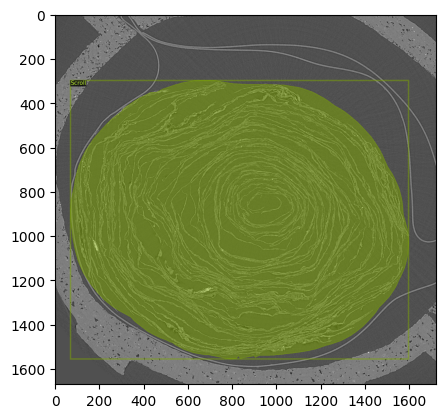

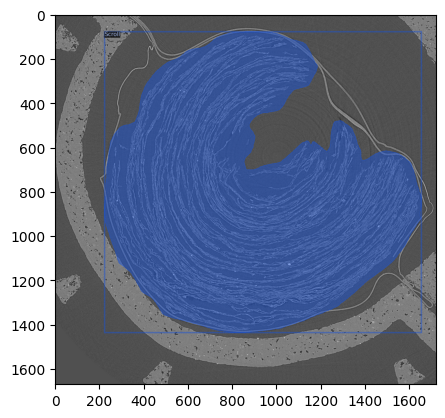

In [12]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [16]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/home/james/Documents/VS/detect-a-scroll/checkpoints"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 24  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.
# Set the checkpoint period
cfg.SOLVER.CHECKPOINT_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=True) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[03/16 17:55:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [17]:
trainer.train() #Start the training process

[03/16 17:55:48 d2.engine.train_loop]: Starting training from iteration 2000
[03/16 17:56:11 d2.utils.events]:  eta: 2:28:00  iter: 2019  total_loss: 0.0408  loss_cls: 0.006367  loss_box_reg: 0.006975  loss_mask: 0.02692  loss_rpn_cls: 5.632e-06  loss_rpn_loc: 0.0006601    time: 1.0861  last_time: 1.1303  data_time: 0.2880  last_data_time: 0.2547   lr: 0.00025  max_mem: 15195M
[03/16 17:56:33 d2.utils.events]:  eta: 2:28:53  iter: 2039  total_loss: 0.04099  loss_cls: 0.006522  loss_box_reg: 0.006751  loss_mask: 0.02742  loss_rpn_cls: 4.438e-06  loss_rpn_loc: 0.0006414    time: 1.0870  last_time: 1.0217  data_time: 0.2560  last_data_time: 0.2575   lr: 0.00025  max_mem: 15195M
[03/16 17:56:54 d2.utils.events]:  eta: 2:27:28  iter: 2059  total_loss: 0.04151  loss_cls: 0.006437  loss_box_reg: 0.006907  loss_mask: 0.02776  loss_rpn_cls: 4.9e-06  loss_rpn_loc: 0.0006454    time: 1.0848  last_time: 1.1110  data_time: 0.2582  last_data_time: 0.2564   lr: 0.00025  max_mem: 15195M
[03/16 17:57:1

KeyboardInterrupt: 

In [19]:

import yaml
# Save the configuration to a config.yaml files
# Save the configuration to a config.yaml file
config_yaml_path = "/home/james/Documents/VS/detect-a-scroll/demo/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [20]:

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/16 18:24:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/james/Documents/VS/detect-a-scroll/checkpoints/model_final.pth ...


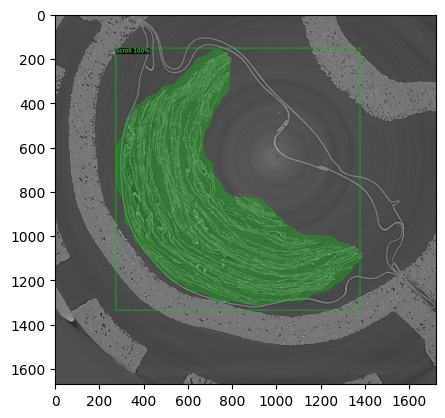

In [21]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [03/16 18:24:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 18:24:43 d2.data.datasets.coco]: Loaded 2 images in COCO format from /home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val/val.json
[03/16 18:24:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Scroll   | 1            |
|            |              |
[03/16 18:24:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/16 18:24:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/16 18:24:43 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[03/16 18:24:43 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/16 18:24:43 d2.evaluatio

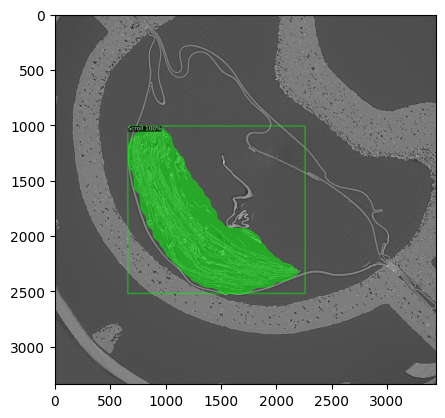

In [23]:
new_im = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/00250.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])